In [1]:
%%HTML  
<style> code {background-color : orange !important;} </style>

# Import library

In [2]:
%matplotlib inline
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
import io
import base64
import pandas as pd # Import pandas and read in csv file as a dataframe
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip
from IPython.display import HTML
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
imageio.plugins.ffmpeg.download()


# Define global value

## Static variable

In [3]:
example_rock = '../calibration_images/example_rock1.jpg'
rock_img = mpimg.imread(example_rock)
imgY_size = rock_img.shape[0]
imgX_size = rock_img.shape[1]
# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','


# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[rock_img.shape[1]/2 - dst_size, rock_img.shape[0] - bottom_offset],
                  [rock_img.shape[1]/2 + dst_size, rock_img.shape[0] - bottom_offset],
                  [rock_img.shape[1]/2 + dst_size, rock_img.shape[0] - 2*dst_size - bottom_offset], 
                  [rock_img.shape[1]/2 - dst_size, rock_img.shape[0] - 2*dst_size - bottom_offset],
                  ])

## OTSU method

In [4]:
#OTSU thresholding function
def otsu_threshold(im):
    pixel_counts = [np.sum(im == i) for i in range(256)]
    s_max = (0,-1)
    ss = []
    for threshold in range(256):
        w_0 = sum(pixel_counts[:threshold]) #  pixels below the threshold
        w_1 = sum(pixel_counts[threshold:]) 
        mu_0 = sum([i * pixel_counts[i] for i in range(0,threshold)]) / w_0 if w_0 > 0 else 0
        # pixels average value below the threshold
        mu_1 = sum([i * pixel_counts[i] for i in range(threshold, 256)]) / w_1 if w_1 > 0 else 0
        # formula
        s = 1.0 * w_0 * w_1 * (mu_0 - mu_1) ** 2
        # Integer overflow if use w_0 * w_1 directly, then * 1.0 to float
        ss.append(s)
        # get the max value
        if s > s_max[1]:
            s_max = (threshold, s)
    return s_max[0]

# Perspective

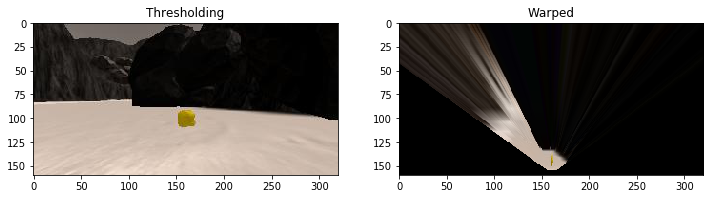

In [5]:
# each grid cell is 1 square meter in the simulator
def perspect_transform(img):   
    M = cv2.getPerspectiveTransform(source, destination)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0])) # keep same size as input image
    return warped

tmp_warped = perspect_transform(rock_img)

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('Thresholding')
plt.imshow(rock_img)
plt.subplot(122)
plt.title('Warped')
plt.imshow(tmp_warped)
scipy.misc.imsave('../output/Img2warped.jpg', tmp_warped)

# Color thresholding output single channel binary image

## Navigation and rock area thresholding

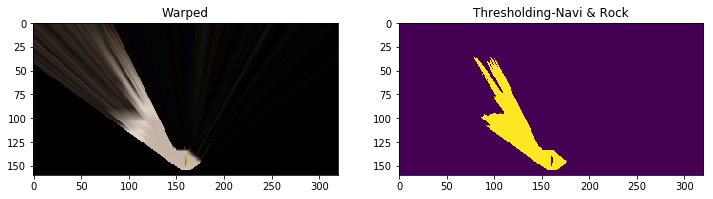

In [6]:
def color_thresh(img): 
    otsu_red = otsu_threshold((img[:,:,0]))
    otsu_green = otsu_threshold((img[:,:,1]))
    otsu_blue = otsu_threshold((img[:,:,2]))
    #print(otsu_red,otsu_green,otsu_blue)
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > otsu_red) \
                & (img[:,:,1] > otsu_green) \
                & (img[:,:,2] > otsu_blue)
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    #print(str(color_select))
    # Return the binary image
    return color_select

tmp_warped = perspect_transform(rock_img)
tmp_threshed = color_thresh(tmp_warped)

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('Warped')
plt.imshow(tmp_warped)
plt.subplot(122)
plt.title('Thresholding-Navi & Rock')
plt.imshow(tmp_threshed)
scipy.misc.imsave('../output/img2warped2thresh.jpg', tmp_threshed*255)

## Obstacle area by invert above thresholding picture

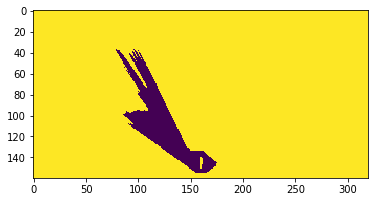

In [7]:
tmp_threshed_obstacle=cv2.bitwise_not(tmp_threshed) # uint8 (160, 320) 254 255
#print(threshed_obstacle.dtype, threshed_obstacle.shape, np.min(threshed_obstacle), np.max(threshed_obstacle))
plt.imshow(tmp_threshed_obstacle)

## Rock area perspective -->thresholding
 - yellow = np.uint8([[[0,255,255]]])  （BGR）
 - hsv_yellow = cv2.cvtColor(yellow,cv2.COLOR_BGR2HSV)
 - hsv_yellow = Yellow HSV value=[[[ 30 255 255]]]  
 then  
 - the lower bound of yellow HSV is [20, 100, 100]
 - the upper bound of yellow HSV is [40, 255, 255]

uint8 (160, 320) 0 255
uint8 (160, 320, 3) 0 178


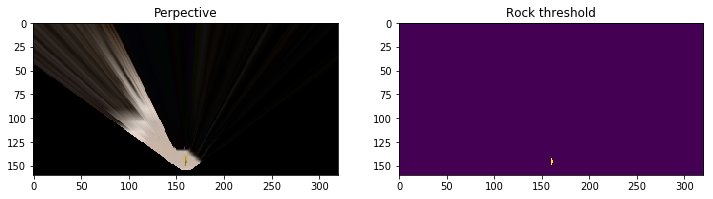

In [8]:
#the lower and upper value is find from Slack Discussion, but should find the good way later
hsv_lower_yellow = np.array([93, 173, 131])
hsv_upper_yellow = np.array([98, 255, 182])
def rock_thresh(warped_img):
    hsv = cv2.cvtColor(warped_img, cv2.COLOR_BGR2HSV)
    # Threshold the HSV image to get only yellow colors
    mask = cv2.inRange(hsv, hsv_lower_yellow, hsv_upper_yellow)
    #bitwise-AND: overlay the mask image and original image
    res = cv2.bitwise_and(warped_img, warped_img, mask = mask)
    return mask, res

tmp_warped = perspect_transform(rock_img)
tmp_mask = rock_thresh(tmp_warped)[0]
tmp_res = rock_thresh(tmp_warped)[1]

print(tmp_mask.dtype, tmp_mask.shape, np.min(tmp_mask), np.max(tmp_mask))
print(tmp_res.dtype, tmp_res.shape, np.min(tmp_res), np.max(tmp_res))

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('Perpective')
plt.imshow(tmp_warped)
plt.subplot(122)
plt.title('Rock threshold')
plt.imshow(tmp_mask)

## Test the code for Rock thresholding  --> Rock perspective 

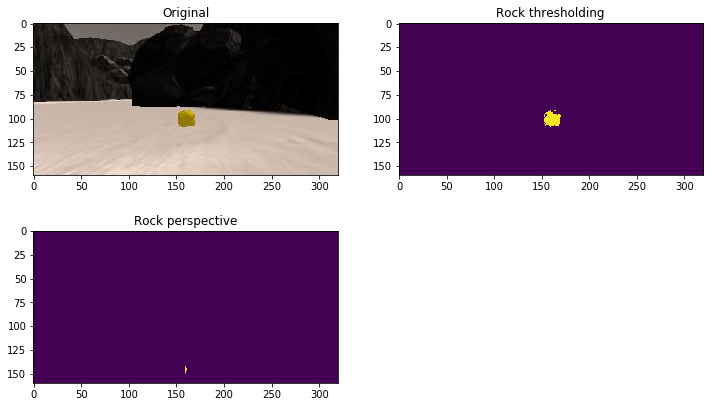

In [9]:

tmp_mask = rock_thresh(rock_img)[0]
tmp_res = rock_thresh(rock_img)[1]
tmp_warped = perspect_transform(tmp_mask)

fig = plt.figure(figsize=(12,7))
plt.subplot(222)
plt.title('Rock thresholding')
plt.imshow(tmp_mask)

plt.subplot(223)
plt.title('Rock perspective')
plt.imshow(tmp_warped)

plt.subplot(221)
plt.title('Original')
plt.imshow(rock_img)

# Navigation area border test code
 - include gold rock area
 - rover can only be active within the navigation area border (need identify gold rock area and pickup)

Y max=154
Y min=37
X max=175
X min=79
uint8 (160, 320) 0 1


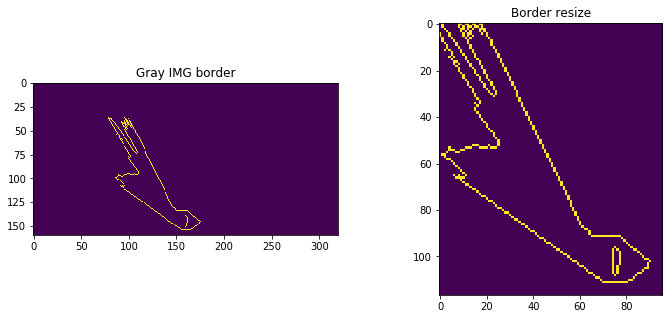

In [10]:
# print(warped_border.dtype, warped_border.shape, np.min(warped_border), np.max(warped_border))
# cv2.CHAIN_APPROX_NONE存储所有的轮廓点，相邻的两个点的像素位置差不超过1，即max（abs（x1-x2），abs（y2-y1））==1
tmp_warped = perspect_transform(rock_img)
tmp_img_threshed = color_thresh(tmp_warped)

border_img,contours,hierarchy = cv2.findContours(tmp_img_threshed,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)  
img_warped_border = cv2.drawContours(tmp_img_threshed,contours,-1,(255,0,0),1) 

grayimg_border = np.uint8(img_warped_border/255)

# get the max, min value of Y
ymax = np.amax(grayimg_border.nonzero()[0])
ymin = np.amin(grayimg_border.nonzero()[0])



print('Y max='+ str(ymax)) 
print('Y min='+ str(ymin))

# get the max, min value of X
xmax = np.amax(grayimg_border.nonzero()[1])
xmin = np.amin(grayimg_border.nonzero()[1])
print('X max='+ str(xmax)) 
print('X min='+  str(xmin))
img_resize = grayimg_border[ymin+6:ymax+6,xmin+6:xmax+6]

print(grayimg_border.dtype, grayimg_border.shape, np.min(grayimg_border), np.max(grayimg_border))
fig = plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Gray IMG border')
plt.imshow(grayimg_border)
plt.subplot(122)
plt.title('Border resize')
plt.imshow(img_resize)

# Convert image coordinate to rover-centric coordinate

X_ymin= [ 15.]
Ymin= [-15.]
[ 21.21320344] [-0.78539816]
-0.785398163397


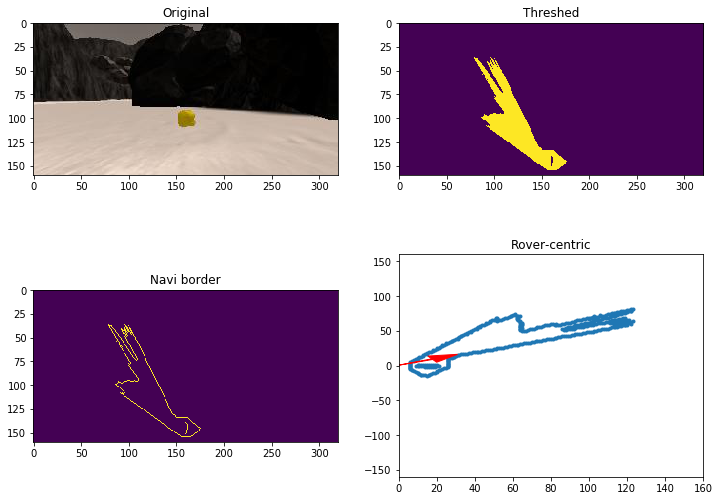

In [11]:
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    #print(binary_img)
    #print(ypos, xpos)
    # Calculate pixel positions with reference to the rover position being at the center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
tmp_warped = perspect_transform(rock_img)
tmp_img_threshed = color_thresh(tmp_warped)
scipy.misc.imsave('../output/grayimg_border.jpg',grayimg_border*255)



tmp_xpix, tmp_ypix = rover_coords(grayimg_border)
tmp_dist, tmp_angles = to_polar_coords(tmp_xpix, tmp_ypix)
tmp_mean_dir = np.mean(tmp_angles)

X_ymin =tmp_xpix[(tmp_ypix == np.amin(tmp_ypix))]
Ymin = np.zeros(len(X_ymin))+np.amin(tmp_ypix)
min_dis, min_angels = to_polar_coords(X_ymin, Ymin)

print('X_ymin= '+str(X_ymin))
print('Ymin= ' + str(Ymin))
print(min_dis, min_angels)
print(np.mean(min_angels))



# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(rock_img)
plt.title('Original')
plt.subplot(222)
plt.imshow(tmp_img_threshed)
plt.title('Threshed')
plt.subplot(223)
plt.imshow(grayimg_border)
plt.title('Navi border')
plt.subplot(224)
plt.plot(tmp_xpix, tmp_ypix, '.')
plt.title('Rover-centric')

#plt.ylim(-160, 160)
plt.ylim(- tmp_img_threshed.shape[1]/2,  tmp_img_threshed.shape[1]/2)
plt.xlim(0, tmp_img_threshed.shape[0])

#draw the red arrow
arrow_length = 20
x_arrow = arrow_length * np.cos(tmp_mean_dir)
y_arrow = arrow_length * np.sin(tmp_mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=1)

# Map the rover-centric coordinate to world map location by the rotation matrix & scale

In [12]:
df = pd.read_csv('../record_data/robot_log.csv', delimiter=';', decimal='.')

# used filter for valid Rover.img

#print('Befor filter Lendf= '+str(len(df)))
#idx_for_df = abs(df["Pitch"].values < 0.1) & abs(df["Roll"].values < 0.1)  
#df  = df[idx_for_df]
csv_img_list = df["Path"].tolist() # Create list of image pathnames
#print('After filter Lendf= '+str(len(df)))
#print('csv_img_list Len= '+str(len(csv_img_list)))


# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)
#RGB(0,255,0) = lime color
scale = 10 # 1 pix means 1 x 1 meter in the world map
# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the simulator
class Databucket():  # this is the bucket for all images
    def __init__(self):
            self.images = csv_img_list  
            self.xpos = df["X_Position"].values
            self.ypos = df["Y_Position"].values
            self.yaw = df["Yaw"].values
            self.pitch = df["Pitch"].values
            self.roll = df["Roll"].values
            self.count = 0 # This will be a running index
            self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
            self.ground_truth = ground_truth_3d # Ground truth worldmap
        

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()
#White=RGB(255.255.255); navigation dodgerblue=RGB(30,144,255), obstacle # red color RGB(255,0,0), gold rock yellow RGB(255,255,0)

Random Xpos = [ 109.79251868] Random Ypos = [ 165.05314903] Random Yaw = [ 212.74732952]
Figure(720x432)


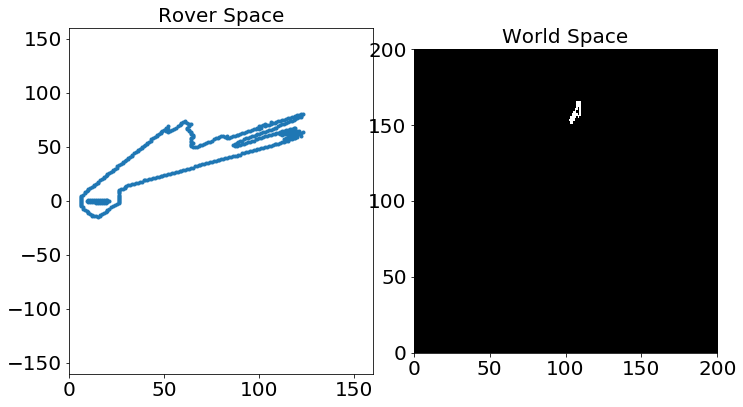

In [13]:
# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world


# rover_yaw; rever_xpos; rover_ypos will get from the file'robot_log.csv' in the following chapter
# Here for function parameter, we will get them in random and just show in the black world map. 
# the rover yaw values will come as floats from 0 to 360
# Generate a random value in this range
# Note: convert the rover_yaw to pixel_angles in the function 'rotate_pix()'
rover_yaw = np.random.random(1)*360
# Generate a random rover position in world coords
# Position values will range from 20 to 180 to 
# avoid the edges in a 200 x 200 pixel world
rover_xpos = np.random.random(1)*160 + 20
rover_ypos = np.random.random(1)*160 + 20

tmp_warped = perspect_transform(rock_img)
tmp_img_threshed = color_thresh(tmp_warped)

tmp_xpix, tmp_ypix = rover_coords(grayimg_border)
tmp_worldmap = np.zeros((200, 200)) #fixed worldmap size
# Get navigable pixel positions in world coords
x_world, y_world = pix_to_world(tmp_xpix, tmp_ypix, rover_xpos, 
                                rover_ypos, rover_yaw, 
                                tmp_worldmap.shape[0], scale)

# Add pixel positions to worldmap
tmp_worldmap[y_world, x_world] += 1
print('Random Xpos =', rover_xpos, 'Random Ypos =', rover_ypos, 'Random Yaw =', rover_yaw)
#print(tmp_xpix, tmp_ypix)



# Plot the map in rover-centric coords
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
f.tight_layout()
ax1.plot(tmp_xpix, tmp_ypix, '.')
ax1.set_title('Rover Space', fontsize=20)
ax1.set_ylim(-160, 160)
ax1.set_xlim(0, 160)
ax1.tick_params(labelsize=20)

ax2.imshow(tmp_worldmap, cmap='gray')
ax2.set_title('World Space', fontsize=20)
ax2.set_ylim(0, 200)
ax2.tick_params(labelsize=20)
ax2.set_xlim(0, 200)

test_img = plt.gcf()
print(test_img)

plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0.1)





# Process the recorded image*('robot_log.csv') *and return integration picture frame for video

## Test code for process_image(img)

Random Xpos = [ 71.77955401] Random Ypos = [ 167.68356124] Random Yaw = [ 276.31919073]


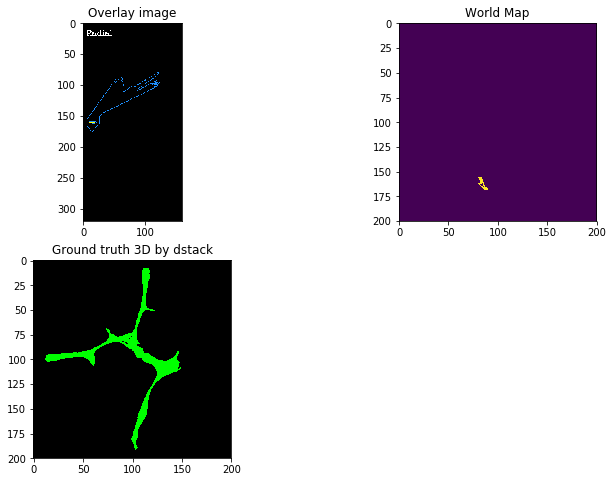

In [14]:
# as question on the top of this page, I don't know how to change image coordinates, have to write a new function here
def rover_coords_map(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the center bottom of the image.  
    # x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    # y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    x_pixel = (binary_img.shape[0] - ypos).astype(np.float)
    y_pixel = (xpos).astype(np.float)
    return x_pixel, y_pixel

def overlay_radial_image(x_navi,y_navi,x_rock,y_rock):
    navi_rover_img = np.zeros((border_img.shape[1],border_img.shape[0],3)).astype(np.uint8)
    navi_rover_img[np.int_(y_navi),np.int_(x_navi),0] = 30
    navi_rover_img[np.int_(y_navi),np.int_(x_navi),1] = 144
    navi_rover_img[np.int_(y_navi),np.int_(x_navi),2] = 255
    
    # rock coordinates set to yellow
    navi_rover_img[np.int_(y_rock),np.int_(x_rock),0] = 255
    navi_rover_img[np.int_(y_rock),np.int_(x_rock),1] = 255
    navi_rover_img[np.int_(y_rock),np.int_(x_rock),2] = 0
    
    radial_txt=('Radial')
    cv2.putText(navi_rover_img,radial_txt, (5,20), cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    return navi_rover_img

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world


# rover_yaw; rever_xpos; rover_ypos will get from the file'robot_log.csv' in the following chapter
# Here for function parameter, we will get them in random and just show in the black world map. 
# the rover yaw values will come as floats from 0 to 360
# Generate a random value in this range
# Note: convert the rover_yaw to pixel_angles in the function 'rotate_pix()'
rover_yaw = np.random.random(1)*360
# Generate a random rover position in world coords,Position values will range from 20 to 180 to avoid the edges in a 200 x 200 pixel world
rover_xpos = np.random.random(1)*160 + 20
rover_ypos = np.random.random(1)*160 + 20

tmp_warped = perspect_transform(rock_img)
tmp_img_threshed = color_thresh(tmp_warped)
tmp_mask_rock,tmp_res_rock = rock_thresh(rock_img)
tmp_warped_rock = perspect_transform(tmp_mask_rock)

border_img,contours,hierarchy = cv2.findContours(tmp_img_threshed,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)  
img_warped_border = cv2.drawContours(tmp_img_threshed,contours,-1,(255,0,0),1) 
grayimg_border = np.uint8(img_warped_border/255)

tmp_xpix, tmp_ypix = rover_coords_map(grayimg_border)
tmp_xrock, tmp_yrock = rover_coords_map(tmp_warped_rock)

tmp_worldmap = np.zeros((200, 200)) #fixed worldmap size
# Get navigable pixel positions in world coords
x_world, y_world = pix_to_world(tmp_xpix, tmp_ypix, rover_xpos, 
                                rover_ypos, rover_yaw, 
                                tmp_worldmap.shape[0], scale)
x_rock_w, y_rock_w = pix_to_world(tmp_xrock, tmp_yrock, rover_xpos, 
                                rover_ypos, rover_yaw, 
                                tmp_worldmap.shape[0], scale)
# Add pixel positions to worldmap
tmp_worldmap[y_world, x_world] += 1

print('Random Xpos =', rover_xpos, 'Random Ypos =', rover_ypos, 'Random Yaw =', rover_yaw)


'''tmp_xpix, tmp_ypix = rover_coords(tmp_img_threshed)
# coordinate scope
plt.xlim((0, 160))
plt.ylim((-160, 160))

# lable
#plt.xlabel('X axis')
#plt.ylabel('Y axis')

#gca = get current axis
ax = plt.gca()
xmajorLocator   = MultipleLocator(50) # X Scale 
xmajorFormatter = FormatStrFormatter('%g')   
#xminorLocator   = MultipleLocator(5)  
ymajorLocator   = MultipleLocator(50) #Y Scale
ymajorFormatter = FormatStrFormatter('%g') 
#yminorLocator   = MultipleLocator(0.1) 
ax.xaxis.set_major_locator(xmajorLocator)  
ax.xaxis.set_major_formatter(xmajorFormatter)  
ax.yaxis.set_major_locator(ymajorLocator)  
ax.yaxis.set_major_formatter(ymajorFormatter)  
  
#ax.xaxis.set_minor_locator(xminorLocator)  
#ax.yaxis.set_minor_locator(yminorLocator)  

# set right and top frame is none
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
# set X as bottom line
ax.xaxis.set_ticks_position('bottom')
# set Y as left line
ax.yaxis.set_ticks_position('left')
# set the position of (0, 0)
ax.spines['bottom'].set_position(('data', -160))
ax.spines['left'].set_position(('data', 0))
#plt.plot(overlay_radial_image_new(rock_img))
plt.plot(tmp_xpix, tmp_ypix, '.')
plt.show()


f, (ax1) = plt.subplots(1, 1,figsize=(5, 6))
f.tight_layout()
ax1.plot(tmp_xpix, tmp_ypix, '.')
ax1.set_title('Rover Space', fontsize=20)
ax1.set_ylim(-160, 160)
ax1.set_xlim(0, 160)
ax1.tick_params(labelsize=20)
'''

fig = plt.figure(figsize=(12,8))
plt.subplot(221)
plt.imshow(overlay_radial_image(tmp_xpix,tmp_ypix,tmp_xrock,tmp_yrock))
plt.title('Overlay image')
plt.subplot(222)
plt.title('World Map')
plt.imshow(tmp_worldmap)

plt.subplot(223)
plt.title('Ground truth 3D by dstack')
plt.imshow(ground_truth_3d.astype(np.uint8))

## Process_image code

map_add : float64 (200, 200, 3) 0.0 255.0


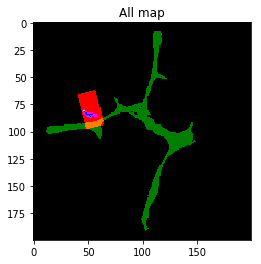

In [15]:
worldmap =  np.zeros((200, 200, 3), dtype=np.float)

rover_yaw = np.random.random(1)*360
rover_xpos = np.random.random(1)*160 + 20
rover_ypos = np.random.random(1)*160 + 20

tmp_warped = perspect_transform(rock_img)
wp_th_imgNavi = color_thresh(tmp_warped)
wp_th_imgObs = 1-wp_th_imgNavi
#wp_th_imgObs = ~wp_th_imgNavi
wp_th_imgRock_mask, wp_th_imgRock_res = (rock_thresh(tmp_warped))
wp_th_imgRock_mask = (wp_th_imgRock_mask/255).astype(np.uint8)
x_obs_rc, y_obs_rc = rover_coords(wp_th_imgObs)
x_rock_rc, y_rock_rc = rover_coords(wp_th_imgRock_mask)
x_navi_rc, y_navi_rc = rover_coords(wp_th_imgNavi+wp_th_imgRock_mask)

x_navi_world, y_navi_world = pix_to_world(x_navi_rc, y_navi_rc, rover_xpos, 
                                rover_ypos, rover_yaw, 
                                200, 10)
x_obs_world, y_obs_world = pix_to_world(x_obs_rc, y_obs_rc, rover_xpos, 
                                rover_ypos, rover_yaw, 
                                200, 10)
x_rock_world, y_rock_world = pix_to_world(x_rock_rc, y_rock_rc, rover_xpos, 
                                rover_ypos, rover_yaw, 
                                200, 10)

worldmap[y_obs_world, x_obs_world, 0] += 1
worldmap[y_rock_world, x_rock_world, 1] += 1
worldmap[y_navi_world, x_navi_world, 2] += 1

map_add = cv2.addWeighted(worldmap*255, 1, ground_truth_3d, 0.5, 0)

print('map_add : '+str(map_add.dtype), map_add.shape, np.min(map_add), np.max(map_add))

plt.title('All map')
plt.imshow((map_add).astype(np.uint8))
scipy.misc.imsave('../output/all_map.jpg', map_add)

## Integration process image for video
- Show the navigation and rock border for reference

In [16]:
# function to pass stored images ()(Databucket()) parameters
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # to print the current x, y and yaw values use print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])
    #create a blank image, size (y-vertical,x-width,3 color channels)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
    
    # populate regions of the image with various output:    
    output_image[0:img.shape[0], img.shape[1]:] = img  #Original image put in the upper right hand corner
 
    wponly_img = perspect_transform(img)
    wp_th_imgNavi = color_thresh(wponly_img)
    wp_th_imgObs = 1-wp_th_imgNavi
    #wp_th_imgObs = ~wp_th_imgNavi
    wp_th_imgRock_mask, wp_th_imgRock_res = (rock_thresh(wponly_img))
    wp_th_imgRock_mask = (wp_th_imgRock_mask/255).astype(np.uint8)
    x_obs_rc, y_obs_rc = rover_coords(wp_th_imgObs)
    x_rock_rc, y_rock_rc = rover_coords(wp_th_imgRock_mask)
    x_navi_rc, y_navi_rc = rover_coords(wp_th_imgNavi+wp_th_imgRock_mask)

    # put the integrated  radial coordinates image in the left
    output_image[0:imgY_size, 0:imgX_size] = tmp_warped
    
    '''Update worldmap (to be displayed on right side of screen)
       Example: data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
       data.worldmap[rock_y_world, rock_x_world, 1] += 1
       data.worldmap[navigable_y_world, navigable_x_world, 2] += 1
    '''
    x_navi_rc, y_navi_rc = rover_coords(tmp_img_threshed)
   # x_obs_rc, rr_ypix = rover_coords(tmp_mask)
   #tmp_threshed_obstacle=cv2.bitwise_not(tmp_warped_img)
   #or_xpic, or_ypix = rover_coords(tmp_threshed_obstacle)
    rover_yaw = data.yaw[data.count]
    rover_xpos = data.xpos[data.count]
    rover_ypos = data.ypos[data.count]
    x_navi_world, y_navi_world = pix_to_world(x_navi_rc, y_navi_rc, rover_xpos, 
                                rover_ypos, rover_yaw, 
                                200, 10)
    x_obs_world, y_obs_world = pix_to_world(x_obs_rc, y_obs_rc, rover_xpos, 
                                rover_ypos, rover_yaw, 
                                200, 10)
    x_rock_world, y_rock_world = pix_to_world(x_rock_rc, y_rock_rc, rover_xpos, 
                                rover_ypos, rover_yaw, 
                                200, 10)
    data.worldmap[y_obs_world, x_obs_world, 0] += 1
    data.worldmap[y_rock_world, x_rock_world, 1] += 1
    data.worldmap[y_navi_world, x_navi_world, 2] += 1   
    
    
    # Overlay worldmap with ground truth map 
    #addWeighted(InputArray src1, double alpha, InputArray src2, double beta, double gamma, OutputArray dst, int dtype=-1)
    map_add = cv2.addWeighted(data.worldmap*255, 1, data.ground_truth, 0.5, 0)
    
    # Flip the entries in each column in the up/down direction. Rows are preserved, but appear in a different order than before
    # in and then add to output_image right bottom corner
    output_image[img.shape[0]:, img.shape[1]:(img.shape[1]+data.worldmap.shape[1])] = np.flipud(map_add)
   
   # Then putting some text over the image
    show_txt='XPOS='+str(data.xpos[data.count])+'; YPOS='+str(data.ypos[data.count])+'; YAW='+str(data.yaw[data.count])
    cv2.putText(output_image,show_txt, (20, output_image.shape[0]-30,), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    if data.count < len(data.images) - 1:
        data.count += 1 # Keep track of the index in the Databucket()
    return output_image


# Save the outputed Vedio to the folder 'output'

In [17]:
output = '../output/recordImg2Video_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=50) # Note: output video will be sped up because recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ../output/recordImg2Video_mapping.mp4
[MoviePy] Writing video ../output/recordImg2Video_mapping.mp4


100%|████████████████████████████████████████| 426/426 [01:17<00:00,  5.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/recordImg2Video_mapping.mp4 

Wall time: 1min 17s


# Play the video as an inline video player

In [18]:
HTML("""
<video width="960" height="600" controls>
  <source src="{0}">
</video>
""".format(output))

# an alternative way to create a video in case the above cell did not work.

In [19]:
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))